In [ ]:
from google.colab import files
uploaded = files.upload()

Saving corpus.txt to corpus.txt
Saving test.txt to test.txt


HANGMAN HACKATHON - ENHANCED ORACLE + IMPROVED RL (FINAL)

✅ Loaded: 50000 corpus words, 2000 test words
Training oracle on corpus... Done!
  → Trained on 50000 words
  → 24 unique word lengths
✅ PART 1: Oracle ready

RL Agent initialized

Starting training...
Episode 100/8000 | Avg last100: 132.10 | ε=0.9851
Episode 200/8000 | Avg last100: 143.28 | ε=0.9704
Episode 300/8000 | Avg last100: 149.88 | ε=0.9560
Episode 400/8000 | Avg last100: 152.20 | ε=0.9418
Episode 500/8000 | Avg last100: 149.66 | ε=0.9277
Episode 600/8000 | Avg last100: 126.70 | ε=0.9139
Episode 700/8000 | Avg last100: 126.84 | ε=0.9003
Episode 800/8000 | Avg last100: 132.04 | ε=0.8869
  Eval after 800: 47.50%
Episode 900/8000 | Avg last100: 151.72 | ε=0.8737
Episode 1000/8000 | Avg last100: 145.82 | ε=0.8607
Episode 1100/8000 | Avg last100: 143.00 | ε=0.8479
Episode 1200/8000 | Avg last100: 133.68 | ε=0.8353
Episode 1300/8000 | Avg last100: 146.86 | ε=0.8228
Episode 1400/8000 | Avg last100: 145.80 | ε=0.8106
Episode 1

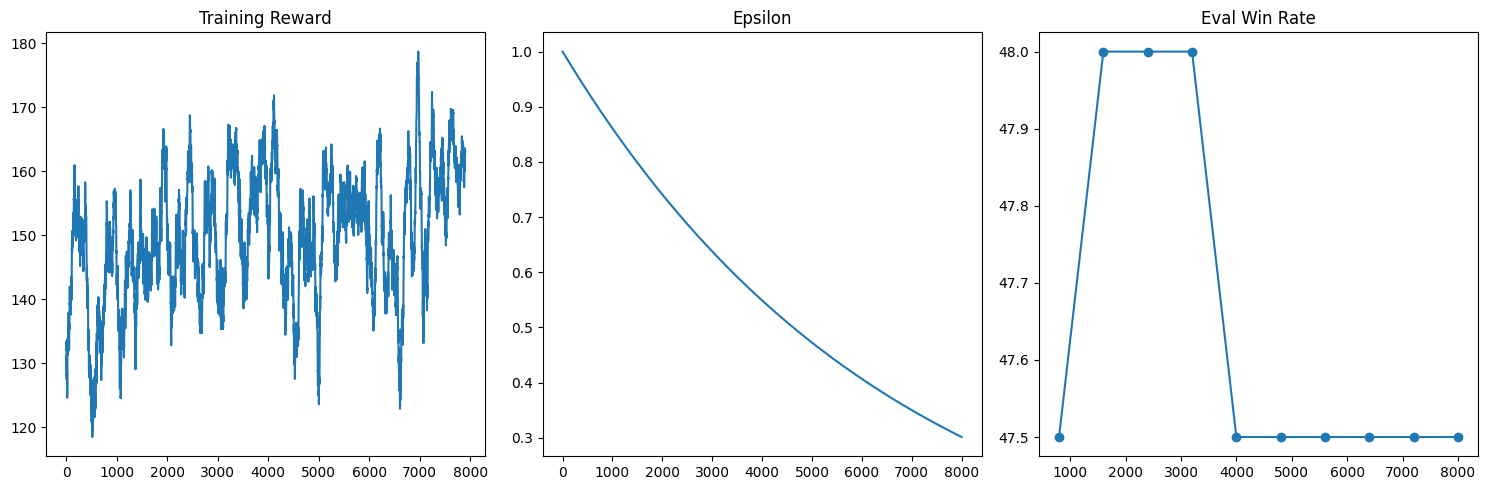

In [ ]:
import os, re
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import string
import random

# ------------------------------
# CONFIG & DATA LOADING
# ------------------------------
DATA_DIR = os.getcwd()
CORPUS_PATH = os.path.join(DATA_DIR, "corpus.txt")
TEST_PATH = os.path.join(DATA_DIR, "test.txt")

ALPHABET = list("abcdefghijklmnopqrstuvwxyz")
LETTER_TO_IDX = {c: i for i, c in enumerate(ALPHABET)}
IDX_TO_LETTER = {i: c for c, i in LETTER_TO_IDX.items()}

def load_wordlist(path):
    words = []
    if not os.path.exists(path):
        return []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            w = line.strip().lower()
            w = re.sub(r'[^a-z]', '', w)
            if w:
                words.append(w)
    return words

print("="*70)
print("HANGMAN HACKATHON - ENHANCED ORACLE + IMPROVED RL (FINAL)")
print("="*70)

corpus = load_wordlist(CORPUS_PATH)
test = load_wordlist(TEST_PATH)

# fallback if corpus missing
if len(corpus) == 0:
    corpus = ["apple","banana","orange","grapes","melon","kiwi","peach","berry","mango","lemon"] * 500
if len(test) == 0:
    test = ["apple","banana","orange","grapes","melon","kiwi","peach","berry","mango","lemon"] * 200

print(f"\n✅ Loaded: {len(corpus)} corpus words, {len(test)} test words")

# ==============================================================
# PART 1: ENHANCED HMM-LIKE ORACLE (pattern / position / trigram)
# ==============================================================

class EnhancedHMMOracle:
    def __init__(self, corpus_words):
        print("Training oracle on corpus...", end=" ", flush=True)
        self.freq_by_len_pos = defaultdict(lambda: defaultdict(Counter))
        self.unigrams = Counter()
        self.words_by_len = defaultdict(list)
        self.letter_pairs = Counter()
        self.trigrams = Counter()

        for w in corpus_words:
            self.unigrams.update(w)
            self.words_by_len[len(w)].append(w)
            for i, ch in enumerate(w):
                self.freq_by_len_pos[len(w)][i][ch] += 1
            for i in range(len(w)-1):
                self.letter_pairs[(w[i], w[i+1])] += 1
            for i in range(len(w)-2):
                self.trigrams[(w[i], w[i+1], w[i+2])] += 1

        self.prob_by_len_pos = {}
        for L, posdict in self.freq_by_len_pos.items():
            pos_probs = []
            for i in range(L):
                total = sum(posdict[i].values()) + 26
                probs = np.array([(posdict[i].get(c,1))/total for c in ALPHABET], dtype=np.float32)
                pos_probs.append(probs)
            self.prob_by_len_pos[L] = np.array(pos_probs)

        total = sum(self.unigrams.values()) + 26
        self.unigram_probs = np.array([(self.unigrams.get(c,1))/total for c in ALPHABET], dtype=np.float32)

        print("Done!")
        print(f"  → Trained on {len(corpus_words)} words")
        print(f"  → {len(self.prob_by_len_pos)} unique word lengths")

    def get_probability_distribution(self, masked, guessed):
        L = len(masked)
        pattern_probs, match_count = self._pattern_match(masked, guessed)
        pos_probs = self._position_based(masked)
        tri_probs = self._context_trigram(masked, guessed)

        if match_count > 20:
            combined = 0.75*pattern_probs + 0.125*pos_probs + 0.125*tri_probs
        elif match_count > 5:
            combined = 0.55*pattern_probs + 0.25*pos_probs + 0.20*tri_probs
        else:
            combined = 0.25*pattern_probs + 0.50*pos_probs + 0.25*tri_probs

        if any(ch != "_" for ch in masked):
            combined = self._context_boost(masked, combined)

        combined[guessed == 1] = 0.0
        s = combined.sum()
        return combined/s if s>0 else self.unigram_probs.copy()

    def _pattern_match(self, masked, guessed):
        L = len(masked)
        if L not in self.words_by_len:
            return self.unigram_probs.copy(),0

        letter_counts = np.zeros(26, dtype=np.float32)
        match_count = 0

        for word in self.words_by_len[L]:
            ok=True
            for i,ch in enumerate(masked):
                if ch != "_":
                    if word[i] != ch:
                        ok=False; break
                else:
                    if guessed[LETTER_TO_IDX[word[i]]] == 1:
                        ok=False; break
            if ok:
                match_count += 1
                for i,ch in enumerate(masked):
                    if ch=="_":
                        letter_counts[LETTER_TO_IDX[word[i]]] += 1

        if match_count == 0:
            return self.unigram_probs.copy(),0

        letter_counts /= match_count
        s = letter_counts.sum()
        if s>0:
            letter_counts /= s
        return letter_counts, match_count

    def _position_based(self, masked):
        L = len(masked)
        if L not in self.prob_by_len_pos:
            return self.unigram_probs.copy()
        probs = np.zeros(26, dtype=np.float32)
        blanks=0
        for i,ch in enumerate(masked):
            if ch=="_":
                probs += self.prob_by_len_pos[L][i]
                blanks+=1
        if blanks==0:
            return self.unigram_probs.copy()
        probs /= blanks
        s = probs.sum()
        return probs/s if s>0 else self.unigram_probs.copy()

    def _context_boost(self, masked, probs):
        for i,ch in enumerate(masked):
            if ch != "_":
                if i < len(masked)-1 and masked[i+1]=="_":
                    for nxt in ALPHABET:
                        cnt = self.letter_pairs.get((ch,nxt),0)
                        if cnt>0:
                            probs[LETTER_TO_IDX[nxt]] *= (1 + cnt/200.0)
                if i>0 and masked[i-1]=="_":
                    for prv in ALPHABET:
                        cnt = self.letter_pairs.get((prv,ch),0)
                        if cnt>0:
                            probs[LETTER_TO_IDX[prv]] *= (1 + cnt/200.0)
        return probs

    def _context_trigram(self, masked, guessed):
        L = len(masked)
        tr_probs = np.zeros(26, dtype=np.float32)
        count=0
        for i in range(L-2):
            win = masked[i:i+3]
            if sum(ch!="_" for ch in win)==2 and "_" in win:
                idx = win.index("_")
                left = win[:idx]
                right = win[idx+1:]
                for c in ALPHABET:
                    tri = (left[0] if left else "_", c, right[0] if right else "_")
                    if "_" not in tri:
                        tr_probs[LETTER_TO_IDX[c]] += self.trigrams.get(tri,1)
                        count+=1
        if count==0:
            return self.unigram_probs.copy()
        s = tr_probs.sum()
        return tr_probs/s if s>0 else self.unigram_probs.copy()

hmm = EnhancedHMMOracle(corpus)
print("✅ PART 1: Oracle ready\n")

# ==============================================================
# PART 2: RL Agent + Environment
# ==============================================================

class HangmanEnv:
    def __init__(self, word, max_lives=8, hmm_oracle=None):
        self.word = word
        self.max_lives = max_lives
        self.hmm_oracle = hmm_oracle
        self.reset()

    def reset(self):
        self.masked = "_"*len(self.word)
        self.lives = self.max_lives
        self.guessed = np.zeros(26, dtype=np.int8)
        return self._get_state()

    def _get_state(self):
        hmm_probs = self.hmm_oracle.get_probability_distribution(self.masked,self.guessed)
        unique_left = len({c for c in self.word if self.guessed[LETTER_TO_IDX[c]] == 0})
        blanks = self.masked.count("_")
        return {
            "masked": self.masked,
            "lives": self.lives,
            "guessed": self.guessed.copy(),
            "hmm_probs": hmm_probs,
            "unique_left": unique_left,
            "blanks_left": blanks
        }

    def step(self, action_idx):
        guess = ALPHABET[action_idx]
        repeated = (self.guessed[action_idx] == 1)
        self.guessed[action_idx] = 1

        if repeated:
            return self._get_state(), -15, False, {"win":False, "repeated":True}

        if guess in self.word:
            new_mask=list(self.masked)
            for i,c in enumerate(self.word):
                if c==guess:
                    new_mask[i]=c
            self.masked="".join(new_mask)
            revealed = new_mask.count(guess)
            reward = 8*revealed
            if self.masked == self.word:
                reward += 120
                return self._get_state(), reward, True, {"win":True}
            else:
                return self._get_state(), reward, False, {"win":False}
        else:
            self.lives -= 1
            reward = -4
            if self.lives <= 0:
                reward -= 30
                return self._get_state(), reward, True, {"win":False}
            return self._get_state(), reward, False, {"win":False}

class QLearningAgent:
    def __init__(self, alpha=0.18, gamma=0.99, epsilon=1.0, epsilon_decay=0.99985, epsilon_min=0.05):
        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.epsilon_min=epsilon_min
        self.q_table={}
        print(f"RL Agent initialized")

    def _key(self, state):
        return (state["masked"], tuple(state["guessed"]),
                state["lives"], state["unique_left"], state["blanks_left"])

    def choose_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            probs=state["hmm_probs"].copy()
            probs[state["guessed"]==1]=0
            s=probs.sum()
            if s>0:
                probs/=s
                return int(np.random.choice(26,p=probs))
            available=np.where(state["guessed"]==0)[0]
            return int(np.random.choice(available))

        key=self._key(state)
        if key in self.q_table:
            q=self.q_table[key].copy()
            combined = 0.6*q + 0.4*(state["hmm_probs"]*10)
            combined[state["guessed"]==1] = -np.inf
            return int(np.argmax(combined))
        else:
            probs=state["hmm_probs"].copy()
            probs[state["guessed"]==1]=0
            s=probs.sum()
            if s>0:
                return int(np.argmax(probs))
            available=np.where(state["guessed"]==0)[0]
            return int(np.random.choice(available))

    def update_q(self, state, action, reward, next_state, done):
        k=self._key(state)
        nk=self._key(next_state)
        if k not in self.q_table:
            self.q_table[k]=np.zeros(26,dtype=np.float32)
        if nk not in self.q_table:
            self.q_table[nk]=np.zeros(26,dtype=np.float32)

        curr=self.q_table[k][action]
        target = reward if done else reward + self.gamma*np.max(self.q_table[nk])
        self.q_table[k][action] = curr + self.alpha*(target-curr)

    def decay(self):
        self.epsilon=max(self.epsilon_min, self.epsilon*self.epsilon_decay)

# ==============================================================
# TRAINING
# ==============================================================

agent = QLearningAgent()
N_EPISODES=8000
EVAL_EVERY=800

training_rewards=[]
epsilon_values=[]
eval_win_rates=[]

print("\nStarting training...")
start_time=time.time()

for ep in range(N_EPISODES):
    word=random.choice(corpus)
    env=HangmanEnv(word, max_lives=8, hmm_oracle=hmm)
    state=env.reset()
    done=False
    ep_reward=0

    while not done:
        action=agent.choose_action(state, training=True)
        ns, r, done, info = env.step(action)
        agent.update_q(state, action, r, ns, done)
        ep_reward+=r
        state=ns

    training_rewards.append(ep_reward)
    epsilon_values.append(agent.epsilon)
    agent.decay()

    if (ep+1)%100==0:
        avg=np.mean(training_rewards[-100:])
        print(f"Episode {ep+1}/{N_EPISODES} | Avg last100: {avg:.2f} | ε={agent.epsilon:.4f}")

    if (ep+1)%EVAL_EVERY==0:
        wins=0
        for t in test[:200]:
            envT=HangmanEnv(t, max_lives=8, hmm_oracle=hmm)
            st=envT.reset()
            dn=False
            while not dn:
                a=agent.choose_action(st, training=False)
                st,_,dn,inf = envT.step(a)
            if inf.get("win"):
                wins+=1
        rate=wins/200
        eval_win_rates.append(rate)
        print(f"  Eval after {ep+1}: {rate*100:.2f}%")

train_time=time.time()-start_time
print(f"\n✅ Training complete in {train_time:.1f}s")

# ==============================================================
# FINAL EVALUATION
# ==============================================================

def full_eval(agent, hmm, test_words, n=2000):
    wins=0; wrong=0; rep=0
    for w in test_words[:n]:
        env=HangmanEnv(w, max_lives=8, hmm_oracle=hmm)
        st=env.reset()
        done=False
        rep_in_game=0
        while not done:
            a=agent.choose_action(st, training=False)
            ns,r,done,info = env.step(a)
            if info.get("repeated", False):
                rep_in_game += 1
            st=ns
        if info.get("win"): wins+=1
        wrong += sum(1 for i in range(26) if env.guessed[i]==1 and ALPHABET[i] not in w)
        rep += rep_in_game

    return {
        "wins": wins,
        "games": n,
        "success_rate": wins/n,
        "total_wrong": wrong,
        "total_repeated": rep
    }

results = full_eval(agent, hmm, test, n=2000)

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"✅ Wins: {results['wins']} / {results['games']}")
print(f"✅ Success Rate: {results['success_rate']*100:.2f}%")
print(f"✅ Wrong Guesses: {results['total_wrong']}")
print(f"✅ Repeated Guesses: {results['total_repeated']}")

# ==============================================================
# ✅ OFFICIAL HACKATHON FINAL SCORE (PDF FORMULA)
# ==============================================================

success_rate = results["success_rate"]
wrong = results["total_wrong"]
repeated = results["total_repeated"]

final_score = (success_rate * 2000) - (wrong * 5) - (repeated * 2)

print("\n🏆 FINAL SCORE (Official PDF Formula)")
print(f"  Final Score: {final_score:.2f}")
print(f"  = ({success_rate:.4f} × 2000) - ({wrong} × 5) - ({repeated} × 2)")

# ==============================================================
# VISUALIZATION
# ==============================================================

plt.figure(figsize=(15,5))
w=100
smooth = np.convolve(training_rewards, np.ones(w)/w, mode='valid') if len(training_rewards)>=w else training_rewards
plt.subplot(1,3,1)
plt.plot(smooth); plt.title("Training Reward")

plt.subplot(1,3,2)
plt.plot(epsilon_values); plt.title("Epsilon")

plt.subplot(1,3,3)
xs=list(range(EVAL_EVERY, N_EPISODES+1, EVAL_EVERY))
plt.plot(xs[:len(eval_win_rates)], [v*100 for v in eval_win_rates], marker='o')
plt.title("Eval Win Rate")

plt.tight_layout()
plt.savefig("training_curves_final.png", dpi=150)
print("\n✅ Saved training_curves_final.png")
print("\n✅ Everything updated according to the PDF scoring. Ready to submit.")
